# jPCA_base.ipynb

This notebook has the code necessary to implement the jPCA algorithm, as described in:
https://static-content.springer.com/esm/art%3A10.1038%2Fnature11129/MediaObjects/41586_2012_BFnature11129_MOESM225_ESM.pdf

We have $ct$ sample points of a time-variant vector signal $X(t) = [x_1(t), \dots, x_n(t)]$. These sample points are in the matrix $X \in \Re^{ct \times n}$.  
We want to find the skew-symmetric matrix $M in \Re^{n \times n}$ that best fits $\dot{X}(t) = X(t) M$.  
In other words, $M$ minimizes $\| \dot{X} - X M \|^2$ with the Frobenius norm.

Since $M$ is skew-symmetric, it will have $n(n-1)/2$ independent entries, which we arrange into the column vector $k$, and solve the equivalent problem using "unrolled" columns. This is expressed as:  
$k^* = \text{armgin}_{k \in \Re^{n(n-1)/2}} \| \dot{x} - \tilde{X} H k \|_2$,  
where $\tilde{X} \in \Re^{(ct \ n) \times n^2}$ is a block matrix with $n$ copies 
of $X$ in its main diagonal, 
$H \in \Re^{n^2 \times n(n-1)/2}$ is a linear transformation that puts the elements of $k$ into the unrolled version of $M$, and $\dot{x}$ is the unrolled version of $\dot{X}$.

The solution to this problem is $k^* = (\tilde{X} H) \backslash \dot{x}$

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [13]:
# Create the data matrix X
# Each row of corresponds to a different time point

# Creating X by evolving a dynamical system
n = 6 # dimensionality of the data
ct = 200 # number of time points
# Using a linear skew-symmetric matrix
mat = np.random.rand(n,n)-0.5
Msk = mat - mat.transpose()

def dt_fun(t, y):
    return np.matmul(Msk, y)

t0 = 0. # initial time of integration
tf = 6. # final time of integration
X0 = 2.*(np.random.rand(n)-0.5) # initial state
t_points = np.linspace(t0, tf, ct)
sol = solve_ivp(dt_fun, [t0,tf], X0, t_eval=t_points)
X = sol.y.transpose()

# create the block-matrix version of X
Xtilde = sp.linalg.block_diag(*([X]*n))

In [14]:
# Create the H matrix
n = X.shape[1]
ct = X.shape[0]
L = np.zeros((n,n), dtype=int)
c = 0
for row in range(n):
    for col in range(row+1, n):
        L[row, col] = c
        L[col, row] = c
        c += 1
        
H = np.zeros((n*n, int(0.5*n*(n-1))))
for col in range(n):
    for row in range(n):
        if col > row:
            H[n*col+row, L[col,row]] = 1.
        elif row > col:
            H[n*col+row, L[col,row]] = -1.

In [15]:
# Approximate the derivatives of X
Xp1 = np.zeros_like(X)
t_bit = t_points[1] - t_points[0]
Xp1[1:,:] = (X[1:,:] - X[:-1,:]) / t_bit

Xp2 = np.gradient(X, t_bit, axis=0)

# Test the derivatives matrix
Xp3 = np.matmul(X, Msk) # "true" derivatives
Xp1_err = np.linalg.norm(Xp3 - Xp1)
Xp2_err = np.linalg.norm(Xp3 - Xp2)
print("Xp1_err=%f, Xp2_err=%f" % (Xp1_err, Xp2_err))

Xp = Xp2 # choose one of the derivatives matrices

xp = Xp.flatten('F')

Xp1_err=32.632446, Xp2_err=32.693051


In [16]:
# calculate the solution directly from the formula
kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)

# reconstruct the matrix Msk that generated the data
Mstar = np.matmul(H, kstar).reshape(n,n)
print(Mstar)
print(Msk)

[[ 0.         -0.87492942 -0.33716968 -0.04359055 -0.05262286 -0.0927051 ]
 [ 0.87492942  0.          0.22689569  0.38260296  0.08977242 -0.21640548]
 [ 0.33716968 -0.22689569  0.         -0.06918127  0.01041199  0.26217198]
 [ 0.04359055 -0.38260296  0.06918127  0.         -0.35446711 -0.43503631]
 [ 0.05262286 -0.08977242 -0.01041199  0.35446711  0.          0.32071967]
 [ 0.0927051   0.21640548 -0.26217198  0.43503631 -0.32071967  0.        ]]
[[ 0.         -0.87495543 -0.33721716 -0.04370017 -0.05267404 -0.09251367]
 [ 0.87495543  0.          0.22715275  0.38267835  0.08993875 -0.21668188]
 [ 0.33721716 -0.22715275  0.         -0.06946601  0.01018009  0.26259947]
 [ 0.04370017 -0.38267835  0.06946601  0.         -0.35436797 -0.435119  ]
 [ 0.05267404 -0.08993875 -0.01018009  0.35436797  0.          0.32079594]
 [ 0.09251367  0.21668188 -0.26259947  0.435119   -0.32079594  0.        ]]


In [17]:
# Frobenius norm of the matrix difference
#Mstar = Mstar.transpose()
norm1 = np.linalg.norm(Mstar - Msk)
print(norm1)

# Angle between Mstar and Msk
angM = np.arccos( (Mstar*Msk).sum() / (np.linalg.norm(Mstar)*np.linalg.norm(Msk) + 1e-8))
print(angM)

# Frobenius norm of derivatives matrix minus its reconstruction
Xp_rec = np.matmul(X, Mstar)
norm2 = np.linalg.norm(Xp - Xp_rec)
print(norm2)

# Angle between Xp and its reconstruction
ang = np.arccos( (Xp * Xp_rec).sum() / (np.linalg.norm(Xp)*np.linalg.norm(Xp_rec) + 1e-8) )
print(ang)

0.0010678155373827702
0.000556670858608758
32.69372810695688
3.140026326108017


In [18]:
# print H and the auxiliary matrices
print("H =")
print(H, end='\n\n')
print("L =")
print(L, end='\n\n')

k = np.arange(1,int(0.5*n*(n-1)+1))
print("k =")
print(k, end='\n\n')
M = np.matmul(H,k)
print("M =")
print(M, end='\n\n')

H =
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  

In [19]:
# 2) Coefficients of determination
# 2.1) Obtain unconstrained M matrix
M_uncons = np.matmul(np.linalg.pinv(X), Xp)
# 2.2) Reconstruct Xp with M_uncons
Xp_uncons = np.matmul(X, M_uncons)
# 2.3) Reconstruct Xp with Mstar
Xp_skew = np.matmul(X, Mstar)
# 2.4) Calculate residual sums of squares
SSres_uncons = ((Xp - Xp_uncons) * (Xp - Xp_uncons)).sum()
SSres_skew = ((Xp - Xp_skew) * (Xp - Xp_skew)).sum()
# 2.5) Calculate the total sum of squares
SStot = ((Xp-Xp.mean())*(Xp-Xp.mean())).sum()
# 2.6) Calculate coefficients of determination
R2_uncons = 1. - (SSres_uncons / SStot)
R2_skew = 1. - (SSres_skew / SStot)

print("R2 unconstrained: %f" % (R2_uncons))
print("R2 skew symmetric: %f" % (R2_skew))

R2 unconstrained: 0.999998
R2 skew symmetric: -3.077698


In [20]:
# 2) Coefficients of determination with "true" derivatives
# 2.1) Obtain unconstrained M matrix
M_uncons = np.matmul(np.linalg.pinv(X), Xp3)
# 2.2) Reconstruct Xp with M_uncons
Xp_uncons = np.matmul(X, M_uncons)
# 2.3) Reconstruct Xp with Mstar
Xp_skew = np.matmul(X, Mstar)
# 2.4) Calculate residual sums of squares
SSres_uncons = ((Xp3 - Xp_uncons) * (Xp3 - Xp_uncons)).sum()
SSres_skew = ((Xp3 - Xp_skew) * (Xp3 - Xp_skew)).sum()
# 2.5) Calculate the total sum of squares
SStot = ((Xp3-Xp3.mean())*(Xp3-Xp3.mean())).sum()
# 2.6) Calculate coefficients of determination
R2_uncons = 1. - (SSres_uncons / SStot)
R2_skew = 1. - (SSres_skew / SStot)

print("R2 unconstrained: %f" % (R2_uncons))
print("R2 skew symmetric: %f" % (R2_skew))

R2 unconstrained: 1.000000
R2 skew symmetric: 1.000000


In [49]:
# extract the eigenvalues of M.
eig_vals, eig_vecs = np.linalg.eig(Mstar)
# print(Mstar)
print("Eigenvalues: ")
print(eig_vals)
print("Eigenvectors: ")
print(eig_vecs)

eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
ev_sum = eig_vals_norms.sum()/2.
var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
print("Variance percentages by each conjugate eigenvalue pair")
print(var_percentages)

# We obtain the plane of strongest rotations
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
u1 = u1 / np.linalg.norm(u1)
u2 = u2 / np.linalg.norm(u2)

Eigenvalues: 
[0.00000000e+00+1.06880984j 0.00000000e+00-1.06880984j
 5.55111512e-17+0.65816406j 5.55111512e-17-0.65816406j
 4.16333634e-17+0.247112j   4.16333634e-17-0.247112j  ]
Eigenvectors: 
[[-0.04168185+0.60729288j -0.04168185-0.60729288j -0.06434331+0.1903861j
  -0.06434331-0.1903861j  -0.19980005+0.22170022j -0.19980005-0.22170022j]
 [ 0.65714363+0.j          0.65714363-0.j          0.15907851-0.07755997j
   0.15907851+0.07755997j -0.17517325+0.07845421j -0.17517325-0.07845421j]
 [ 0.14804006+0.11630125j  0.14804006-0.11630125j  0.17733504+0.32307117j
   0.17733504-0.32307117j  0.57335457+0.j          0.57335457-0.j        ]
 [ 0.07365305+0.33078812j  0.07365305-0.33078812j -0.12023105-0.44562317j
  -0.12023105+0.44562317j  0.20216897-0.36227979j  0.20216897+0.36227979j]
 [ 0.11157858-0.01470895j  0.11157858+0.01470895j -0.21930879+0.39342419j
  -0.21930879-0.39342419j -0.17967994-0.50216536j -0.17967994+0.50216536j]
 [ 0.16320069-0.08962278j  0.16320069+0.08962278j -0.61364029

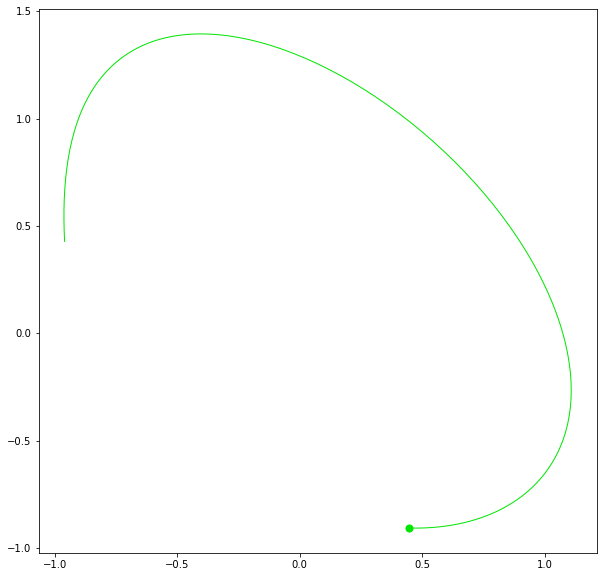

In [56]:
# visualizing components throgh time

J = 1
T = ct
# project activities into the plane of strongest rotations
jPCA1_traces = np.zeros((J, T), dtype=np.float_)
jPCA2_traces = np.zeros((J, T), dtype=np.float_)
u1 = u1.reshape(1,n)
u2 = u2.reshape(1,n)

for target in range(J):
    jPCA1_traces[target, :] = np.matmul(u1, X.transpose())
    jPCA2_traces[target, :] = np.matmul(u2, X.transpose())
    
# RGB colormap. First entry is greenest, last is reddest
cmap = [[0., .9, 0.],
        [0., .7, 0.],
        [0., .5, 0.],
        [0., .2, 0.],
        [.2, 0., 0.],
        [.5, 0., 0.],
        [.7, 0., 0.],
        [.9, 0., 0.]]
t0_jPC1s = [jPCA1_traces[target,0] for target in range(J)]
jPC1_sortr = list(np.argsort(t0_jPC1s))
#t0_jPC1s.sort() # sorting according to initial jPC1 component
jpca_fig =  plt.figure(figsize=(10,10))
for target in range(J):
    c = cmap[jPC1_sortr.index(target)]
    plt.plot(jPCA1_traces[target,:], jPCA2_traces[target,:], color=c, linewidth=1)
    plt.scatter(jPCA1_traces[target,0], jPCA2_traces[target,0], s=50, color=c)

plt.show()

In [55]:
# If you want to see what happens for other vectors
u1 = u1[0,np.random.permutation(6)]
u2 = u2[0,np.random.permutation(6)]

In [27]:
a = np.array([[0,1],[-1,0]])
eig_vals, eig_vecs = np.linalg.eig(a)
print(a)
print("Eigenvalues: ")
print(eig_vals)
print("Eigenvectors: ")
print(eig_vecs)

[[ 0  1]
 [-1  0]]
Eigenvalues: 
[0.+1.j 0.-1.j]
Eigenvectors: 
[[0.70710678+0.j         0.70710678-0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]
